* ASTER TB image
* MODIS TB image
* GOES TB image
* MODIS-ASTER difference: image & histogram
* GOES-ASTER difference: image & histogram

In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Define functions

In [3]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

Set up working area geometry

In [6]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

Find datasets

In [7]:
filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_orthorectified.nc')
#filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_original.nc')

Open all datasets

In [9]:
ds = xr.open_mfdataset(filepaths, concat_dim='time', combine='nested')
ds = ds.rio.clip(geometry)

### Plot one image to make Figure4

And compute summary stats.

In [33]:
_ds

<xarray.Dataset>
Dimensions:                 (x: 499, y: 500)
Coordinates:
  * y                       (y) float64 4.16e+06 4.16e+06 ... 4.205e+06
  * x                       (x) float64 2.826e+05 2.827e+05 ... 3.274e+05
    band                    int64 1
    time                    datetime64[ns] 2019-04-27T18:51:22
    spatial_ref             int64 0
Data variables:
    ast_goes_aster_rad      (y, x) float64 dask.array<chunksize=(500, 499), meta=np.ndarray>
    ast_goes_goes_rad       (y, x) float32 dask.array<chunksize=(500, 499), meta=np.ndarray>
    ast_goes_goes_tb        (y, x) float32 dask.array<chunksize=(500, 499), meta=np.ndarray>
    ast_goes_goes_zones     (y, x) float64 dask.array<chunksize=(500, 499), meta=np.ndarray>
    ast_goes_mean_rad       (y, x) float64 dask.array<chunksize=(500, 499), meta=np.ndarray>
    ast_goes_max_rad        (y, x) float64 dask.array<chunksize=(500, 499), meta=np.ndarray>
    ast_goes_min_rad        (y, x) float64 dask.array<chunksize=(500, 

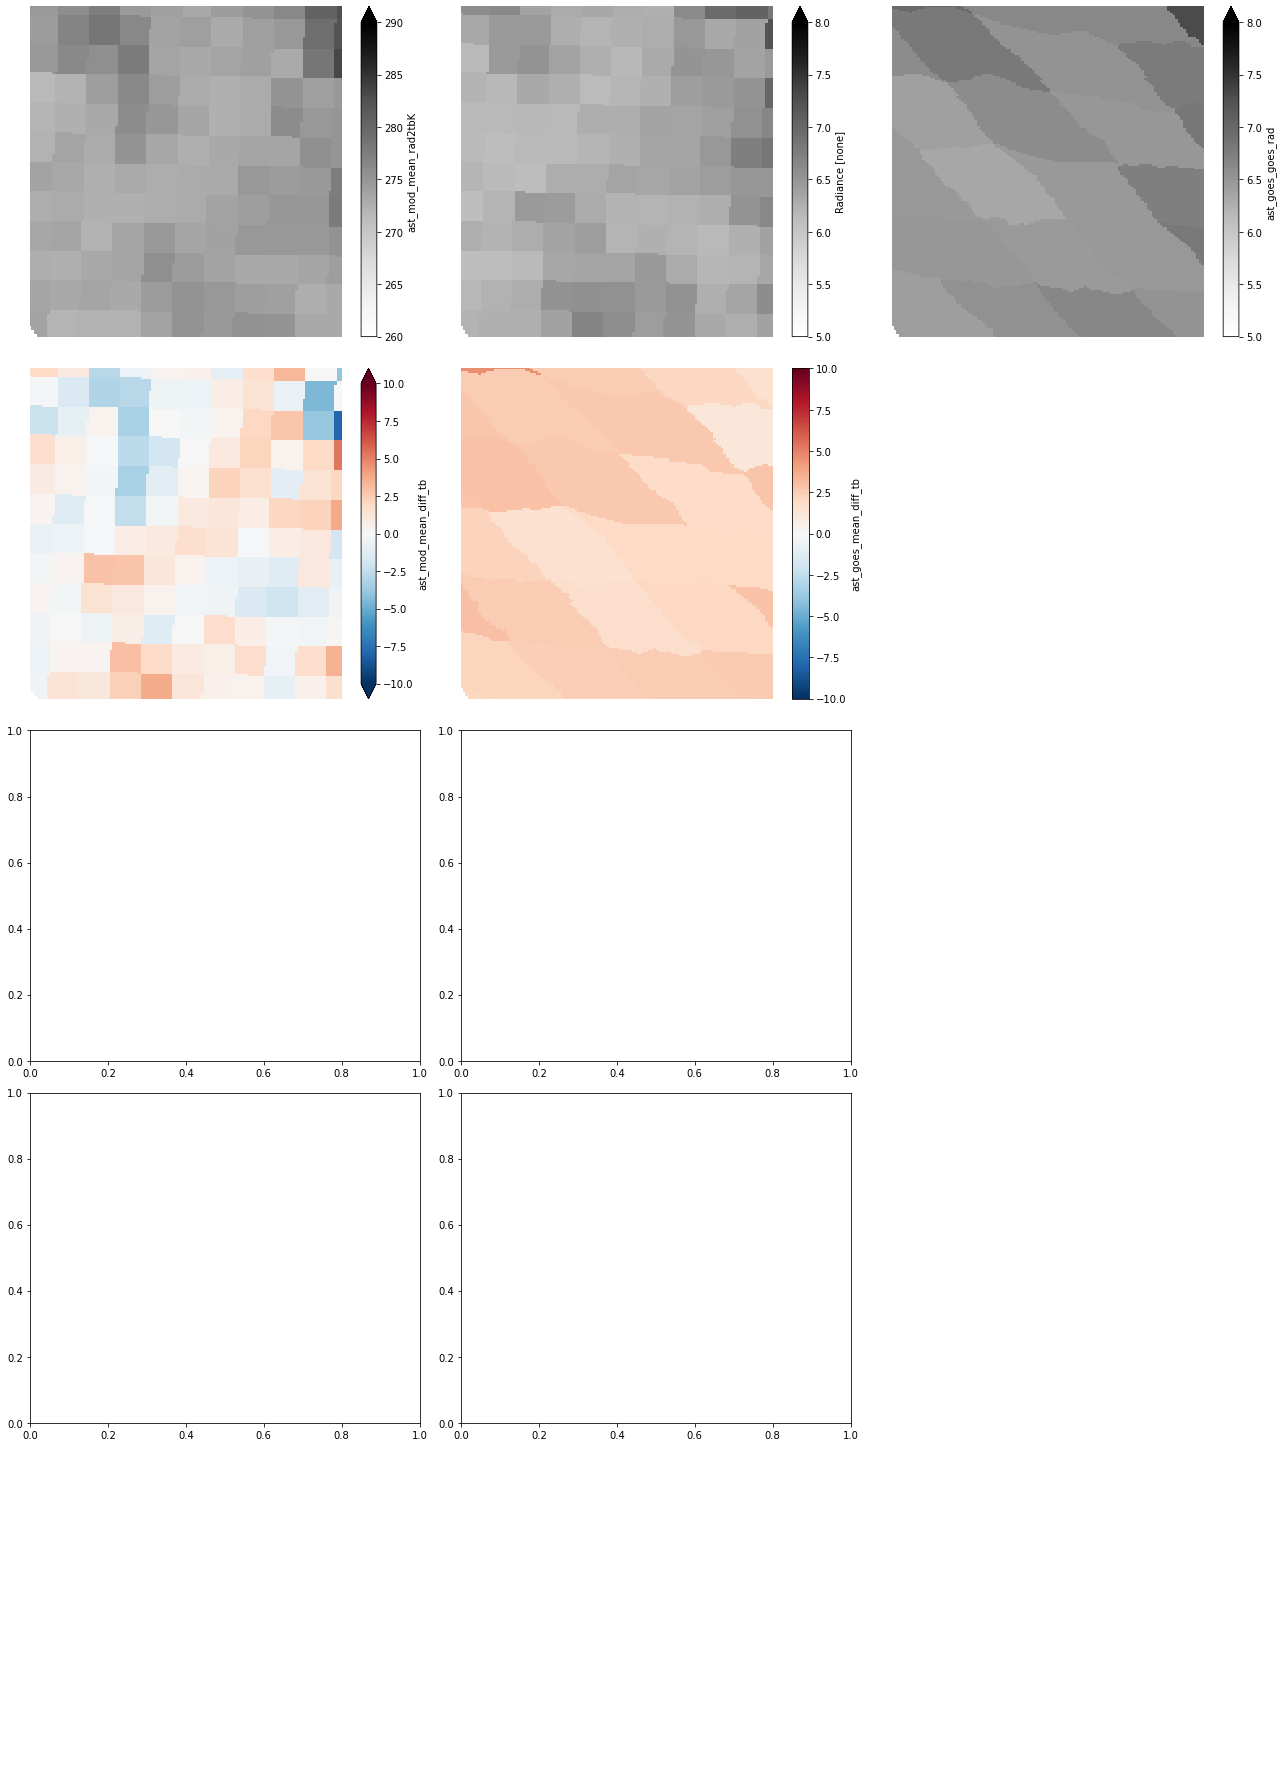

In [49]:
save_figure = True

summary_stats_list = []


    
# Subset dataset to a single time slice
_ds = ds.isel(time=13)
timestep_index = _ds.time

####################################################################################

## Get the CUES and Gaylor Pit temperature observations that were taken at the same time as these satellite images
#print('Looking for {}'.format(ds.time[timestep_index].values))
## CUES
#_cues_ds = cues_ds.sel(timeUTC=ds.time[timestep_index].values, method='nearest')
#print('Found for CUES: {}'.format(_cues_ds.timeUTC.values))
#this_cues_tss = _cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].values
#this_cues_tair = _cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)'].values
##this_cues_rh = _cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)'].values
#
## Gaylor Pit (Tuolumne)
#_tuol_ds = tuol_ds.sel(timeUTC=ds.time[timestep_index].values, method='nearest')
#print('Found for Gaylor Pit: {}'.format(_tuol_ds.timeUTC.values))
#this_tuol_tss = _tuol_ds.tss.values
#this_tuol_tair = _tuol_ds.air_temp_c.values    
#   
####################################################################################

fig = plt.figure(figsize=(18,25), tight_layout=True)

##### Format figure subplots with subplot2grid:
##### ax = subplot2grid((nrows, ncols), (row, col), rowspan, colspan)

nrows = 5
ncols = 3

ax_aster_tb = plt.subplot2grid((nrows, ncols), (0, 0), 1, 1)
ax_modis_tb = plt.subplot2grid((nrows, ncols), (0, 1),  1, 1)
ax_goes_tb = plt.subplot2grid((nrows, ncols), (0, 2), 1, 1)
    
ax_ast_mod_diff = plt.subplot2grid((nrows, ncols), (1, 0), 1, 1)
ax_ast_goes_diff = plt.subplot2grid((nrows, ncols), (1, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (1, 2), 1, 1)
blank.set_axis_off()

ax_ast_mod_hist = plt.subplot2grid((nrows, ncols), (2, 0), 1, 1)
ax_ast_goes_hist = plt.subplot2grid((nrows, ncols), (2, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (2, 2), 1, 1)
blank.set_axis_off()

ax_ast_mod_1to1 = plt.subplot2grid((nrows, ncols), (3, 0), 1, 1)
ax_ast_goes_1to1 = plt.subplot2grid((nrows, ncols), (3, 1), 1, 1)
blank = plt.subplot2grid((nrows, ncols), (3, 2), 1, 1)
blank.set_axis_off()
    
blank = plt.subplot2grid((nrows, ncols), (4, 0), 3, 1)
blank.set_axis_off()

####################################################################################


# make timestamp string for use in figure titles
timestamp_str = str(_ds.time.values).split('.')[0]

### Plot the brightness temperature images ###
# ASTER Tb
_ds.ast_mod_mean_rad2tbK.plot(ax=ax_aster_tb, add_colorbar=True, cmap='Greys', vmin=260, vmax=290)
#ax_aster_tb.set_title('ASTER Band 14\nBrightness Temperature')
# MODIS Tb
_ds.ast_mod_modis_rad.plot(ax=ax_modis_tb, add_colorbar=True, cmap='Greys', vmin=5, vmax=8)
#ax_modis_tb.set_title('MODIS Band 31\nBrightness Temperature')
# GOES Tb
_ds.ast_goes_goes_rad.plot(ax=ax_goes_tb, add_colorbar=True, cmap='Greys', vmin=5, vmax=8)
#ax_goes_tb.set_title('GOES Band 14\nBrightness Temperature')

### Plot the difference maps for MODIS-ASTER, and GOES-ASTER ###
_ds.ast_mod_mean_diff_tb.plot(ax=ax_ast_mod_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
ax_ast_mod_diff.set_title('MODIS - ASTER\nDifference Map')
_ds.ast_goes_mean_diff_tb.plot(ax=ax_ast_goes_diff, add_colorbar=True, cmap='RdBu_r', vmin=-10, vmax=10)
ax_ast_goes_diff.set_title('GOES - ASTER\nDifference Map')

#### Plot the difference histograms for MODIS-ASTER, and GOES-ASTER ###
#_ds.ast_mod_mean_diff_tb.plot.hist(ax=ax_ast_mod_hist, bins=50, color='k')
#ax_ast_mod_hist.axvline(_ds.ast_mod_mean_diff_tb.mean(), color='r', linestyle='--') # mean line
#ax_ast_mod_hist.set_title('MODIS - ASTER\nDifference Histogram')
#_ds.ast_goes_mean_diff_tb.plot.hist(ax=ax_ast_goes_hist, bins=25, color='k')
#ax_ast_goes_hist.axvline(_ds.ast_goes_mean_diff_tb.mean(), color='r', linestyle='--') # mean line
#ax_ast_goes_hist.set_title('GOES - ASTER\nDifference Histogram')
## Format the axes limits on the histograms
#for ax in [ax_ast_mod_hist, ax_ast_goes_hist]:
#    ax.set_xlim(-10,10)
#    #ax.set_ylim()

#### Plot 1-to-1 for MODIS vs ASTER and GOES vs ASTER ##
## ASTER and MODIS
#ax_ast_mod_1to1.plot(_ds.ast_mod_mean_rad2tbK, _ds.ast_mod_modis_tb, # aggregated ASTER vs MODIS
#                      linestyle='none', marker='.', color='k', alpha=1)
##ax_ast_mod_1to1.plot(_ds.ast_mod_aster_rad2tbK, _ds.ast_mod_modis_tb, # subpixel ASTER vs MODIS
##                      linestyle='none', marker='.', color='k', alpha=1)
#ax_ast_mod_1to1.set_title('Mean ASTER vs MODIS\nBrightness Temperature')
#ax_ast_mod_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
#ax_ast_mod_1to1.set_ylabel('MODIS $T_B$ [K]')
## ASTER and GOES
#ax_ast_goes_1to1.plot(_ds.ast_goes_mean_rad2tbK, _ds.ast_goes_goes_tb, # aggregated ASTER vs GOES
#                      linestyle='none', marker='.', color='k', alpha=1)
##ax_ast_goes_1to1.plot(_ds.ast_goes_aster_rad2tbK, _ds.ast_goes_goes_tb, # subpixel ASTER vs GOES
##                      linestyle='none', marker='.', color='k', alpha=1)
#ax_ast_goes_1to1.set_title('Mean ASTER vs GOES\nBrightness Temperature')
#ax_ast_goes_1to1.set_xlabel('Mean ASTER $T_B$ [K]')
#ax_ast_goes_1to1.set_ylabel('GOES $T_B$ [K]')

#### Summary Stats ###
#summary_stats_ast_mod = summary_stats(_ds.ast_mod_mean_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
#summary_stats_ast_subpx_mod = summary_stats(_ds.ast_mod_aster_rad2tbK.values.ravel(), _ds.ast_mod_modis_tb.values.ravel())
#summary_stats_ast_goes = summary_stats(_ds.ast_goes_mean_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
#summary_stats_ast_subpx_goes = summary_stats(_ds.ast_goes_aster_rad2tbK.values.ravel(), _ds.ast_goes_goes_tb.values.ravel())
## compile summary stats into a pandas dataframe
## Update key names
#_summary_stats_ast_mod = { 'ast_mod_'+k: v for k, v in summary_stats_ast_mod.items() }
#_summary_stats_ast_subpx_mod = { 'ast_subpx_mod_'+k: v for k, v in summary_stats_ast_subpx_mod.items() }
#_summary_stats_ast_goes = { 'ast_goes_'+k: v for k, v in summary_stats_ast_goes.items() }
#_summary_stats_ast_subpx_goes = { 'ast_subpx_goes_'+k: v for k, v in summary_stats_ast_subpx_goes.items() }
## merge all three dictionaries together with some other data values
#summary_stats_dict = {'time' : _ds.time.values,
#                      'aster_rad_filepath': _ds.attrs['aster_rad_filepath'],
#                      'modis_rad_filepath': _ds.attrs['modis_rad_filepath'],
#                      'goes_rad_filepath': _ds.attrs['goes_rad_filepath'],
#                      'goes_zones_filepath': _ds.attrs['goes_zones_filepath'],
#                      'goes_tb_filepath': _ds.attrs['goes_tb_filepath'],
#                      **_summary_stats_ast_mod, **_summary_stats_ast_subpx_mod,
#                      **_summary_stats_ast_goes, **_summary_stats_ast_subpx_goes}    
#
#    
## append summary stats to list of all summary stats
#summary_stats_list.append(summary_stats_dict)
#


## 1-to-1 plots and axes formatting
#for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
#    # get max and min values for axes
#    (ax_min, ax_max) = (int(np.floor( np.min( [ax_1_to_1.get_xlim()[0], ax_1_to_1.get_ylim()[0]] ) )), 
#                        int(np.ceil( np.max( [ax_1_to_1.get_xlim()[1], ax_1_to_1.get_ylim()[1]] ) )) )
#    # add 1-to-1 line
#    ax_1_to_1.plot([ax_min,ax_max],[ax_min,ax_max],'k-')
#    # set axes limits
#    ax_1_to_1.set_xlim((ax_min,ax_max))
#    ax_1_to_1.set_ylim((ax_min,ax_max))
#
## Add Gaylor Pit and CUES temperatures to 1-to-1 plots, along the 1-to-1 line:
#for ax_1_to_1 in [ax_ast_mod_1to1, ax_ast_goes_1to1]:
#    ax_1_to_1.plot(this_cues_tss+273.15, this_cues_tss+273.15, color='tab:blue', linestyle='none', marker='P', markersize=12, label='CUES $T_{ss}$')
#    ax_1_to_1.plot(this_tuol_tss+273.15, this_tuol_tss+273.15, color='tab:blue', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_{ss}$')
#    ax_1_to_1.plot(this_cues_tair+273.15, this_cues_tair+273.15, color='tab:green', linestyle='none', marker='P', markersize=12, label='CUES $T_a$')
#    ax_1_to_1.plot(this_tuol_tair+273.15, this_tuol_tair+273.15, color='tab:green', linestyle='none', marker='X', markersize=12, label='Gaylor Pit $T_a$')
#    ax_1_to_1.legend()
    
# Plot an outline of the study area, and Gaylor Pit and CUES markers on the map axes
# Zoom in
for ax in [ax_aster_tb, ax_modis_tb, ax_goes_tb, ax_ast_mod_diff, ax_ast_goes_diff]:
    ax.set_xlim((297250,308000))
    ax.set_ylim((4175000,4190000))
    ax.set_axis_off()
    ax.set_title('')
    
    
    
    #ax.scatter(296649, 4195210, 
    #                    marker='o', 
    #                    edgecolor='k', 
    #                    facecolor='w', 
    #                    s=100, 
    #                    label='Gaylor Pit')
    #ax.scatter(320971, 4168153, 
    #                    marker='o', 
    #                    edgecolor='k', 
    #                    facecolor='w', 
    #                    s=100, 
    #                    label='CUES')
   #ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
   #                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
   #                 linestyle='-', color='k')
   #
    

## add title at bottom of figure    
#fig.suptitle('{}\n{}\n{}\n{}\n{}\n{}'.format(timestamp_str,
#                                     _ds.attrs['aster_rad_filepath'],
#                                     _ds.attrs['modis_rad_filepath'],
#                                     _ds.attrs['goes_rad_filepath'],
#                                     _ds.attrs['goes_zones_filepath'],
#                                     _ds.attrs['goes_tb_filepath']),
#            x=0, y=0.15, ha='left', fontsize=13);
#
filename_friendly_timestamp_str = timestamp_str.replace(':','')

if save_figure == True:
    plt.savefig('./Figure4_{}.jpg'.format(filename_friendly_timestamp_str),dpi=200)

#### Make pandas dataframe from summary stats dictionaries
#summary_stats_df = pd.DataFrame(summary_stats_list)
# save out to csv file
#summary_stats_df.to_csv('goes_modis_aster_orthorectified_tb_summary_stats.csv')
#summary_stats_df.to_csv('fig4.csv')